In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [10]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
base = automap_base()

# reflect the tables
base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = base.classes.measurement
station = base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
inspector = inspect(engine)
measurement_columns = inspector.get_columns('measurement')
for column in measurement_columns:
    print(column["name"],column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [13]:
recent = session.query(measurement.date).order_by(measurement.date.desc()).first()
recent = recent[0]
recent = dt.datetime.strptime(recent, '%Y-%m-%d')

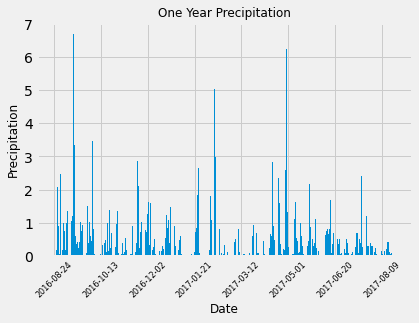

In [17]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
oneYear = recent - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
sel = [measurement.date, measurement.prcp]
yearData = session.query(*sel).filter(measurement.date > oneYear).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_data = pd.DataFrame(yearData, columns=['Date','Precipitation'])
prcp_data = prcp_data.sort_values(['Date'], ascending=True)
prcp_data = prcp_data.set_index('Date')
prcp_data = prcp_data.dropna()

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure()

# Get x and y values 
xAxis = prcp_data.index
yAxis = prcp_data['Precipitation']

# Create x axis ticks 
xTicks = np.arange(0, 400, 50)
plt.xticks(xTicks, rotation=45, fontsize=8) 

# Plot
plt.bar(xAxis,yAxis, align='center')
plt.title(f"One Year Precipitation", fontsize=12)
plt.xlabel("Date (Y,M,D)", fontsize=12)
plt.ylabel("Precipitation (in.)", fontsize=12)
plt.savefig('./data/precipitation.png', format='png')
plt.show()



In [18]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_data.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [24]:
# Design a query to calculate the total number stations in the dataset
stationCount = session.query(station.id).count()
print(stationCount)

9


In [25]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
activeCount = session.query(measurement.station, func.count(measurement.id))\
            .group_by(measurement.station)\
            .order_by(func.count(measurement.id).desc()).all()
activeCount

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [26]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
query = [measurement.station, func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)]
activeStation = session.query(measurement.station)\
            .group_by(measurement.station)\
            .order_by(func.count(measurement.id).desc()).first()
activeStation = activeStation[0]
temps = session.query(*query).filter(measurement.station == activeStation).first()
temps

('USC00519281', 54.0, 85.0, 71.66378066378067)

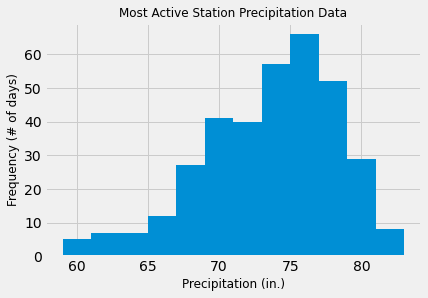

In [29]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
year = session.query(measurement.tobs, measurement.date)\
            .filter(measurement.station == activeStation)\
            .filter(measurement.date > oneYear).all()

# Organize as dataframe
year_df = pd.DataFrame(year, columns=['Temp', 'Date'])
year_df = year_df.set_index('Date')

# Plot data
plt.figure()
tempsNew = year_df['Temp']

# Plot
plt.hist(tempsNew, bins=12, histtype='bar')
plt.title('Most Active Station Precipitation Data', fontsize=12)
plt.ylabel('Frequency (# of days)', fontsize=12)
plt.xlabel('Precipitation (in.)', fontsize=12)
plt.savefig('./data/most_active.png', format='png')
plt.show()

# Close session

In [ ]:
# Close Session
session.close()